# Brain Tumor Detection

Ovaj dokument sadrži sav kod za izradu projekta "Brain Tumor Detection".

### Data

Podaci koje imamo na raspolaganju su MRI slike mozga. Dio slika sadrži MRI snimke bez tumora dok ostatak su slika sa tumorom.
Pogledajmo koliko takvih podataka imamo.

In [1]:
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
import cv2
import imutils
import matplotlib.pyplot as plt
from os import listdir
import seaborn as sns
import numpy as np
import pandas as pd
import os
import time    

%matplotlib inline

          Count
Tumor       155
No tumor     98


<AxesSubplot:>

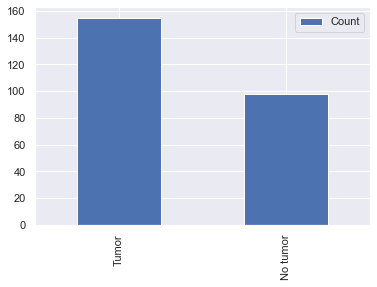

In [2]:
data_path = "brain_tumor_dataset/"
    

sns.set_theme()
count = pd.DataFrame({"Count": [len(os.listdir(data_path + "yes")), len(os.listdir(data_path + "no"))]}, index=["Tumor", "No tumor"])
# count = pd.DataFrame({"Tumor": yes, "No tumor": no}, index=["Count"])
print(count.head())

count.plot(kind="bar")

Iz gornjeg bar charta vidljive su dvije stvari. Imamo neuravnoteženi dataset te premalo poadtaka. 253 zapisa nisu dovoljna za treniranje modela te je potrebno povećati dataset putem tkz. data argumentacije. Na taj način od jedne slike bez tumora stvorit ćemo 9 novih slika, a od slike s tumorom ćemo stvoriti 6 novih slika.

### Data argumentation

In [3]:
def augment_data(file_dir, n_generated_samples, save_to_dir):
    """
        file_dir: dir of original pictures.
        n_generated_samples:  number of generated samples using the given image.
        save_to_dir: dir to save data.
    """
    
    
    data_gen = ImageDataGenerator(rotation_range=10, 
                                  width_shift_range=0.1, 
                                  height_shift_range=0.1, 
                                  shear_range=0.1, 
                                  brightness_range=(0.3, 1.0),
                                  horizontal_flip=True, 
                                  vertical_flip=True, 
                                  fill_mode='nearest'
                                 )

    
    for filename in listdir(file_dir):
        # load the image
        image = cv2.imread(file_dir + '\\' + filename)
        
        # reshape the image
        image = image.reshape((1,)+image.shape)
        
        # prefix of the names for the generated sampels.
        save_prefix = 'aug_' + filename[:-4]
        
        # generate 'n_generated_samples' sample images
        i=0
        for batch in data_gen.flow(x=image, batch_size=1, save_to_dir=save_to_dir, 
                                           save_prefix=save_prefix, save_format='jpg'):
            i += 1
            if i > n_generated_samples:
                break

Kod iznad predstavlja funkciju koja će generirati nove slike na način koji je objašnjen na početku.

In [4]:
start_time = time.time()

augmented_data_path = 'Argumented_Data/'

# YES tumor picutes
augment_data(file_dir=data_path + "yes", n_generated_samples=6, save_to_dir=augmented_data_path+'yes')


# NO tumor pictures
augment_data(file_dir=data_path + "no", n_generated_samples=9, save_to_dir=augmented_data_path+'no')

end_time = time.time()
execution_time = (end_time - start_time)
print("Elapsed time: ",execution_time)

Elapsed time:  102.43380451202393


Generirali smo nove podatke , pogledajmo koliko imamo podataka.

          Count
Tumor      1239
No tumor   1078


<AxesSubplot:>

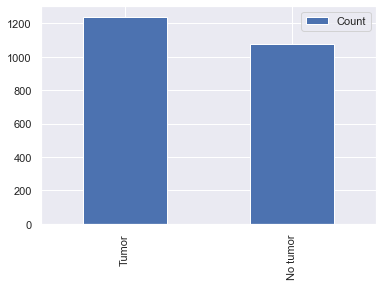

In [5]:
data_path = "brain_tumor_dataset/"
    

sns.set_theme()
count = pd.DataFrame({"Count": [len(os.listdir(data_path + "yes"))+len(os.listdir(augmented_data_path + "yes")), 
                                len(os.listdir(data_path + "no"))+len(os.listdir(augmented_data_path + "no"))] }
                                ,index=["Tumor", "No tumor"])
# count = pd.DataFrame({"Tumor": yes, "No tumor": no}, index=["Count"])
print(count.head())

count.plot(kind="bar")

Sada imamo 1240 slika sa tumorom, te 1078 slika bez tumora. Nemamo savršeni omjer 1:1 između klasa , ali imamo dovoljno dobar omjer.

### Data Preparation & Preprocessing

Generirali smo nove podatke, ali potrebno je detaljnije obraditi te podatke. Znamo da raspolažemo s MRI slikama te da crna pozadina ne nosi nikakvu informaciju. Potrebno je izrezati dio slike koji sadrži samo mozak. To ćemo uraditi na sličan način kao što je objašnjeno na :  https://pyimagesearch.com/2016/04/11/finding-extreme-points-in-contours-with-opencv/

In [6]:
def crop_brain(image, plot=False):
    
    # Convert the image to grayscale, and blur it slightly
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)

    # Threshold the image, then perform a series of erosions +
    # dilations to remove any small regions of noise
    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)

    # Find contours in thresholded image, then grab the largest one
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)
    

    # Find the extreme points
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])
    
    # crop new image out of the original image using the four extreme points (left, right, top, bottom)
    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]    

    #Compare orinal and cropped
    if plot:
        plt.figure()

        plt.subplot(1, 2, 1)
        plt.imshow(image)
        
        plt.tick_params(axis='both', which='both', 
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        
        plt.title('Original Image')
            
        plt.subplot(1, 2, 2)
        plt.imshow(new_image)

        plt.tick_params(axis='both', which='both', 
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)

        plt.title('Cropped Image')
        
        plt.show()
    
    return new_image

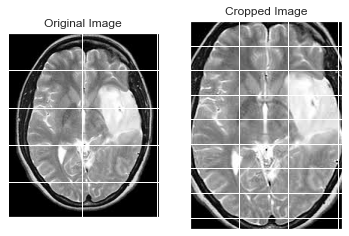

In [7]:
ex_img = cv2.imread('brain_tumor_dataset/yes/Y21.jpg')
ex_new_img = crop_brain(ex_img, True)

Na gornjoj slici je vidljiva razlika između slika. Isti postupak je potrebno provesti nad svim ostalim slikama. Dodatno nakon toga, potrebno je promijeniti veličinu slike jer želimo da sve slike imaju iste dimenzije(240,240,3).
Sljedeći korak je normalizacija , tj. pikseli moraju biti u rasponu 0-1.


In [8]:
from sklearn.utils import shuffle
def image_processing(dir_list, image_width, image_height):

    # load all images in a directory
    X = []
    y = []
    
    
    for directory in dir_list:
        for filename in listdir(directory):
            
            # load the image
            image = cv2.imread(directory + '\\' + filename)
            
            # crop the brain and ignore the unnecessary rest part of the image
            image = crop_brain(image, plot=False)
            
            # resize image
            image = cv2.resize(image, dsize=(image_width, image_height), interpolation=cv2.INTER_CUBIC)
            
            # normalize values
            image = image / 255.
            
            # convert image to numpy array and append it to X
            X.append(image)
            
            #Also appending label to image 1==TUMOR , 0==NO TUMOR
            if directory[-3:] == 'yes':
                y.append([1])
            else:
                y.append([0])
                
    X = np.array(X)
    y = np.array(y)
    
    # Shuffle the data
    X, y = shuffle(X, y)
    
    print(f'Number of examples is: {len(X)}')
    print(f'X shape is: {X.shape}')
    print(f'y shape is: {y.shape}')
    
    return X, y
    

In [9]:
augmented_path = 'Argumented_Data/'

augmented_yes = augmented_path + 'yes' 
augmented_no = augmented_path + 'no'


X, y = image_processing([augmented_yes, augmented_no], 240,240)

Number of examples is: 2064
X shape is: (2064, 240, 240, 3)
y shape is: (2064, 1)


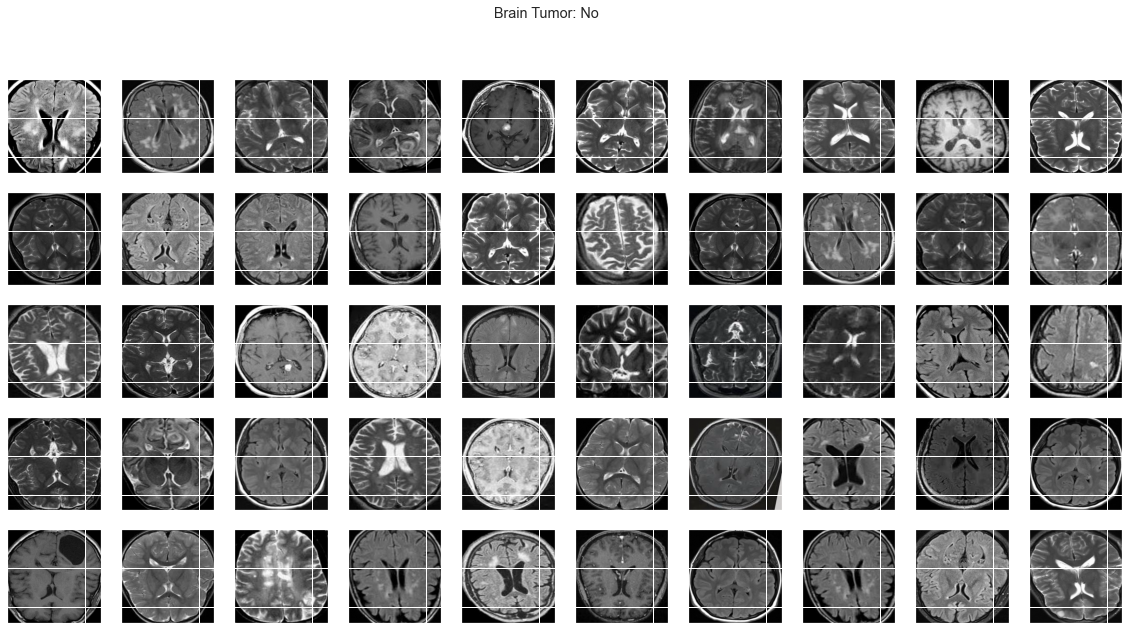

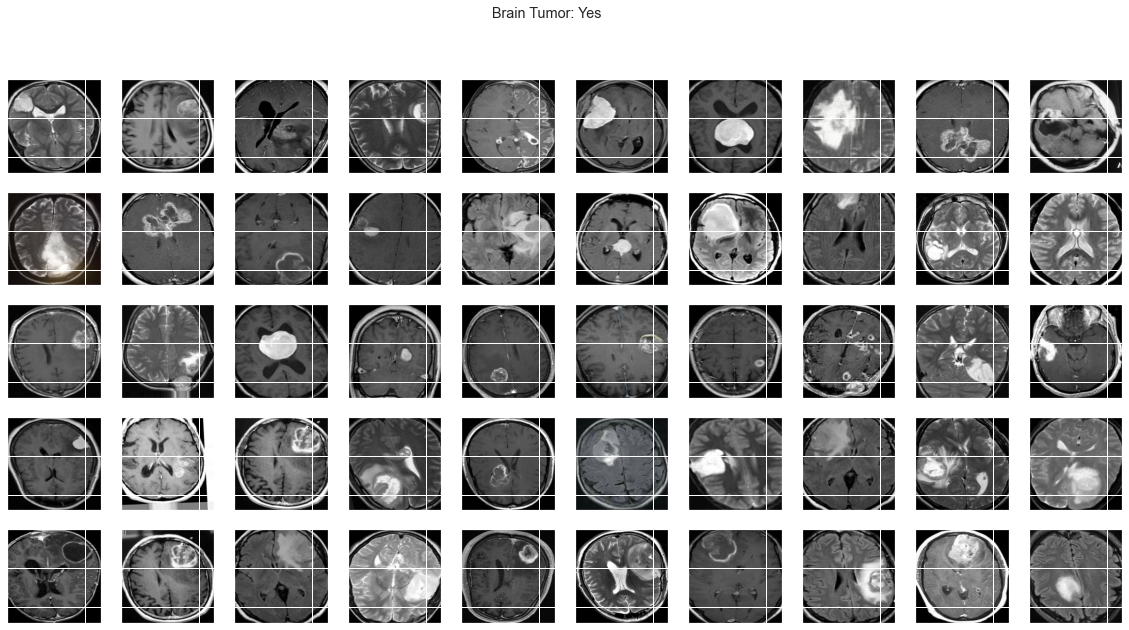

In [10]:
def plot_sample_images(X, y, n=50):
    """
    Plots n sample images for both values of y (labels).
    Arguments:
        X: A numpy array with shape = (#_examples, image_width, image_height, #_channels)
        y: A numpy array with shape = (#_examples, 1)
    """
    
    for label in [0,1]:
        # grab the first n images with the corresponding y values equal to label
        images = X[np.argwhere(y == label)]
        n_images = images[:n]
        
        columns_n = 10
        rows_n = int(n/ columns_n)

        plt.figure(figsize=(20, 10))
        
        i = 1 # current plot        
        for image in n_images:
            plt.subplot(rows_n, columns_n, i)
            plt.imshow(image[0])
            
            # remove ticks
            plt.tick_params(axis='both', which='both', 
                            top=False, bottom=False, left=False, right=False,
                           labelbottom=False, labeltop=False, labelleft=False, labelright=False)
            
            i += 1
        
        label_to_str = lambda label: "Yes" if label == 1 else "No"
        plt.suptitle(f"Brain Tumor: {label_to_str(label)}")
        plt.show()
        
## Plot the images
plot_sample_images(X, y)

Prije izgradnje modela, podijelit ćemo podatke na train,test i validation set

In [11]:
from sklearn.model_selection import train_test_split
def split_data(X, y, test_size=0.2):
    
    X_train, X_test_val, y_train, y_test_val = train_test_split(X, y, test_size=test_size)
    X_test, X_val, y_test, y_val = train_test_split(X_test_val, y_test_val, test_size=0.5)
    
    return X_train, y_train, X_val, y_val, X_test, y_test

X_train, y_train, X_val, y_val, X_test, y_test = split_data(X, y, test_size=0.3)
#70% => train , 15%=> test , 15%=> validation

### Building CNN


Mreža koju ćemo izgraditi ima arhitekturu kao što je prikazano na slici.

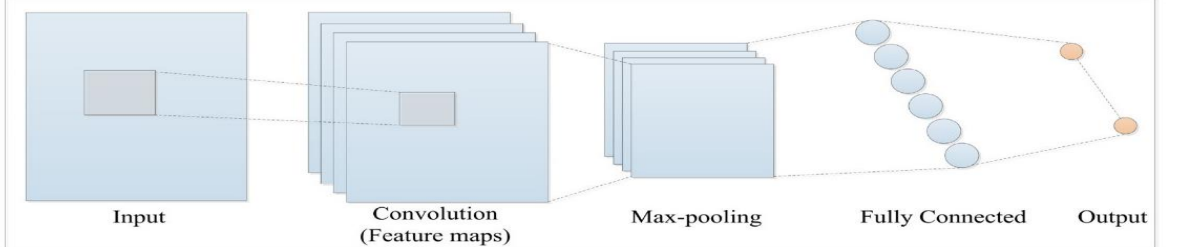

In [35]:
from tensorflow.keras.layers import Conv2D,Dropout, Input, ZeroPadding2D, BatchNormalization, Activation, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
IMG_SIZE=240

def build_model(input_shape):
 
    # Define the input placeholder as a tensor with shape input_shape. 
    X_input = Input(input_shape) # shape=(?, 240, 240, 3)
    
    # Zero-Padding: pads the border of X_input with zeroes
    X = ZeroPadding2D((2, 2))(X_input) # shape=(?, 244, 244, 3)
    
    # CONV -> BN -> RELU Block applied to X
    X = Conv2D(32, (7, 7), strides = (1, 1), name = 'conv0')(X)
    X = BatchNormalization(axis = 3, name = 'bn0')(X)
    X = Activation('relu')(X) # shape=(?, 238, 238, 32)
    
    # MAXPOOL
    X = MaxPooling2D((4, 4), name='max_pool0')(X) # shape=(?, 59, 59, 32) 
    
    # MAXPOOL
    X = MaxPooling2D((4, 4), name='max_pool1')(X) # shape=(?, 14, 14, 32)
    
    # FLATTEN X 
    X = Flatten()(X) # shape=(?, 6272)
    # FULLYCONNECTED
    X = Dense(1, activation='sigmoid', name='fc')(X) # shape=(?, 1)
    
    # Create model. This creates your Keras model instance, you'll use this instance to train/test the model.
    model = Model(inputs = X_input, outputs = X, name='BrainDetectionModel')
    
    return model

In [38]:
model = build_model((240,240,3))
model.summary()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

Model: "BrainDetectionModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 240, 240, 3)]     0         
                                                                 
 zero_padding2d (ZeroPadding  (None, 244, 244, 3)      0         
 2D)                                                             
                                                                 
 conv0 (Conv2D)              (None, 238, 238, 32)      4736      
                                                                 
 bn0 (BatchNormalization)    (None, 238, 238, 32)      128       
                                                                 
 activation (Activation)     (None, 238, 238, 32)      0         
                                                                 
 max_pool0 (MaxPooling2D)    (None, 59, 59, 32)        0         
                                               

In [39]:
# tensorboard
log_file_name = f'brain_tumor_detection_cnn_{int(time.time())}'
tensorboard = TensorBoard(log_dir=f'logs/{log_file_name}')

In [40]:
# checkpoint
# unique file name that will include the epoch and the validation (development) accuracy
filepath="cnn-parameters-improvement-{epoch:02d}-{val_accuracy:.2f}"
# save the model with the best validation (development) accuracy till now
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max'))

### Train the model

In [41]:
import warnings
warnings.filterwarnings('ignore')
start_time = time.time()

model.fit(x=X_train, y=y_train, batch_size=32, epochs=20, validation_data=(X_val, y_val), callbacks=[tensorboard, checkpoint])

end_time = time.time()
execution_time = (end_time - start_time)
print("Elapsed time: ", execution_time)

history = model.history.history


Epoch 1/20
46/46 [==============================] - ETA: 0s - loss: 0.7900 - accuracy: 0.6350

INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-01-0.68.model\assets


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-01-0.68.model\assets


46/46 [==============================] - 78s 2s/step - loss: 0.7900 - accuracy: 0.6350 - val_loss: 0.6450 - val_accuracy: 0.6774
Epoch 2/20
46/46 [==============================] - ETA: 0s - loss: 0.4727 - accuracy: 0.7742

INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-02-0.76.model\assets


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-02-0.76.model\assets


46/46 [==============================] - 73s 2s/step - loss: 0.4727 - accuracy: 0.7742 - val_loss: 0.5996 - val_accuracy: 0.7645
Epoch 3/20
46/46 [==============================] - ETA: 0s - loss: 0.4187 - accuracy: 0.8116

INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-03-0.62.model\assets


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-03-0.62.model\assets


46/46 [==============================] - 74s 2s/step - loss: 0.4187 - accuracy: 0.8116 - val_loss: 0.6179 - val_accuracy: 0.6194
Epoch 4/20
46/46 [==============================] - ETA: 0s - loss: 0.3632 - accuracy: 0.8483

INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-04-0.57.model\assets


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-04-0.57.model\assets


46/46 [==============================] - 75s 2s/step - loss: 0.3632 - accuracy: 0.8483 - val_loss: 0.6404 - val_accuracy: 0.5710
Epoch 5/20
46/46 [==============================] - ETA: 0s - loss: 0.3178 - accuracy: 0.8650

INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-05-0.84.model\assets


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-05-0.84.model\assets


46/46 [==============================] - 77s 2s/step - loss: 0.3178 - accuracy: 0.8650 - val_loss: 0.4617 - val_accuracy: 0.8387
Epoch 6/20
46/46 [==============================] - ETA: 0s - loss: 0.3049 - accuracy: 0.8657

INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-06-0.59.model\assets


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-06-0.59.model\assets


46/46 [==============================] - 76s 2s/step - loss: 0.3049 - accuracy: 0.8657 - val_loss: 0.7149 - val_accuracy: 0.5871
Epoch 7/20
46/46 [==============================] - ETA: 0s - loss: 0.2872 - accuracy: 0.8795

INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-07-0.81.model\assets


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-07-0.81.model\assets


46/46 [==============================] - 78s 2s/step - loss: 0.2872 - accuracy: 0.8795 - val_loss: 0.4185 - val_accuracy: 0.8129
Epoch 8/20
46/46 [==============================] - ETA: 0s - loss: 0.2462 - accuracy: 0.9058

INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-08-0.74.model\assets


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-08-0.74.model\assets


46/46 [==============================] - 78s 2s/step - loss: 0.2462 - accuracy: 0.9058 - val_loss: 0.5366 - val_accuracy: 0.7387
Epoch 9/20
46/46 [==============================] - ETA: 0s - loss: 0.2184 - accuracy: 0.9120

INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-09-0.88.model\assets


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-09-0.88.model\assets


46/46 [==============================] - 74s 2s/step - loss: 0.2184 - accuracy: 0.9120 - val_loss: 0.3692 - val_accuracy: 0.8806
Epoch 10/20
46/46 [==============================] - ETA: 0s - loss: 0.2025 - accuracy: 0.9252

INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-10-0.81.model\assets


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-10-0.81.model\assets


46/46 [==============================] - 75s 2s/step - loss: 0.2025 - accuracy: 0.9252 - val_loss: 0.4609 - val_accuracy: 0.8065
Epoch 11/20
46/46 [==============================] - ETA: 0s - loss: 0.2115 - accuracy: 0.9204

INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-11-0.88.model\assets


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-11-0.88.model\assets


46/46 [==============================] - 76s 2s/step - loss: 0.2115 - accuracy: 0.9204 - val_loss: 0.3467 - val_accuracy: 0.8839
Epoch 12/20
46/46 [==============================] - ETA: 0s - loss: 0.1696 - accuracy: 0.9439

INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-12-0.86.model\assets


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-12-0.86.model\assets


46/46 [==============================] - 78s 2s/step - loss: 0.1696 - accuracy: 0.9439 - val_loss: 0.3576 - val_accuracy: 0.8581
Epoch 13/20
46/46 [==============================] - ETA: 0s - loss: 0.2086 - accuracy: 0.9100

INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-13-0.89.model\assets


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-13-0.89.model\assets


46/46 [==============================] - 83s 2s/step - loss: 0.2086 - accuracy: 0.9100 - val_loss: 0.3381 - val_accuracy: 0.8871
Epoch 14/20
46/46 [==============================] - ETA: 0s - loss: 0.1663 - accuracy: 0.9349

INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-14-0.89.model\assets


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-14-0.89.model\assets


46/46 [==============================] - 77s 2s/step - loss: 0.1663 - accuracy: 0.9349 - val_loss: 0.3406 - val_accuracy: 0.8903
Epoch 15/20
46/46 [==============================] - ETA: 0s - loss: 0.1427 - accuracy: 0.9522

INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-15-0.69.model\assets


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-15-0.69.model\assets


46/46 [==============================] - 74s 2s/step - loss: 0.1427 - accuracy: 0.9522 - val_loss: 0.8932 - val_accuracy: 0.6871
Epoch 16/20
46/46 [==============================] - ETA: 0s - loss: 0.1354 - accuracy: 0.9522

INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-16-0.88.model\assets


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-16-0.88.model\assets


46/46 [==============================] - 75s 2s/step - loss: 0.1354 - accuracy: 0.9522 - val_loss: 0.3514 - val_accuracy: 0.8806
Epoch 17/20
46/46 [==============================] - ETA: 0s - loss: 0.1103 - accuracy: 0.9723

INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-17-0.71.model\assets


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-17-0.71.model\assets


46/46 [==============================] - 76s 2s/step - loss: 0.1103 - accuracy: 0.9723 - val_loss: 0.7926 - val_accuracy: 0.7129
Epoch 18/20
46/46 [==============================] - ETA: 0s - loss: 0.1710 - accuracy: 0.9307

INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-18-0.88.model\assets


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-18-0.88.model\assets


46/46 [==============================] - 79s 2s/step - loss: 0.1710 - accuracy: 0.9307 - val_loss: 0.3711 - val_accuracy: 0.8806
Epoch 19/20
46/46 [==============================] - ETA: 0s - loss: 0.1051 - accuracy: 0.9723

INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-19-0.88.model\assets


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-19-0.88.model\assets


46/46 [==============================] - 81s 2s/step - loss: 0.1051 - accuracy: 0.9723 - val_loss: 0.3706 - val_accuracy: 0.8806
Epoch 20/20
46/46 [==============================] - ETA: 0s - loss: 0.0899 - accuracy: 0.9806

INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-20-0.78.model\assets


INFO:tensorflow:Assets written to: models\cnn-parameters-improvement-20-0.78.model\assets


46/46 [==============================] - 78s 2s/step - loss: 0.0899 - accuracy: 0.9806 - val_loss: 0.5735 - val_accuracy: 0.7839
Elapsed time:  1544.5676019191742


Nacrtajmo graf za train i validation loss.

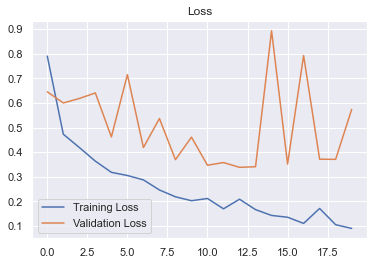

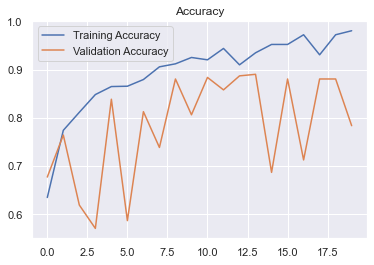

In [43]:
train_loss = history['loss']
val_loss = history['val_loss']
train_acc = history['accuracy']
val_acc = history['val_accuracy']

# Loss
plt.figure()
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Loss')
plt.legend()
plt.show()

# Accuracy
plt.figure()
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Accuracy')
plt.legend()
plt.show()

### Test the model.

In [44]:
##Need the best model ==> the one with the best validation accuracy 0.89
best_model = load_model(filepath='models/cnn-parameters-improvement-13-0.89.model')
best_model.metrics_names

['loss', 'accuracy']

In [45]:
#Test the best model
loss, acc = best_model.evaluate(x=X_test, y=y_test)
print (f"Test Loss = {loss}")
print (f"Test Accuracy = {acc}")

10/10 [==============================] - 4s 303ms/step - loss: 0.3381 - accuracy: 0.8839
Test Loss = 0.3381330370903015
Test Accuracy = 0.8838709592819214
